#Group Members:

1.   Yusraa Khan         (222057003)
2.   Shmeeta Rabinath    (221008055)
3.   Keiasha Gounden     (221001861)

#Imports

In [29]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier, IsolationForest
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, silhouette_score, log_loss, brier_score_loss, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.base import clone
from sklearn.calibration import CalibratedClassifierCV
import xgboost as xgb
import joblib
import matplotlib.pyplot as plt
from itertools import combinations
from collections import Counter

#Data Preprocessing

In [2]:
pl_regSeason = pd.read_csv("cleaned_player_regular.csv")
playoffs = pd.read_csv('cleaned_player_playoffs_careers.csv')

pl_regSeason = pl_regSeason[(pl_regSeason['gp'] > 0) & (pl_regSeason['minutes'] > 0)]

num_cols = pl_regSeason.select_dtypes(include=["float64", "int64"]).columns
scaler = StandardScaler()
pl_regSeason_scaled = scaler.fit_transform(pl_regSeason[num_cols])

pl_regSeason_scaled = pd.DataFrame(pl_regSeason_scaled, columns=num_cols, index=pl_regSeason.index)
pl_regSeason_scaled = pd.concat([pl_regSeason.drop(columns=num_cols), pl_regSeason_scaled], axis=1)

In [3]:
merged = pd.merge(pl_regSeason, playoffs, on='ilkid', how='left', suffixes=('', '_playoff'))
numeric_cols = merged.select_dtypes(include=['int64', 'float64']).columns
merged[numeric_cols] = merged[numeric_cols]

# merging
games_col = 'gp'
pts_col = 'pts'
ast_col = 'asts'
trb_col = 'reb'
stl_col = 'stl'
blk_col = 'blk'

merged['ppg'] = merged[pts_col] / merged[games_col].replace(0,1)
merged['apg'] = merged[ast_col] / merged[games_col].replace(0,1)
merged['rpg'] = merged[trb_col] / merged[games_col].replace(0,1)
merged['spg'] = merged[stl_col] / merged[games_col].replace(0,1)
merged['bpg'] = merged[blk_col] / merged[games_col].replace(0,1)

# Set a minimum games threshold of five to improve outliers
min_playoff_games = 5

merged['playoff_boost'] = np.where(
    merged['gp_playoff'] >= min_playoff_games,
    (merged['pts_playoff'] + merged['asts_playoff'] + merged['reb_playoff']) / merged['gp_playoff'],
    np.nan  # Not enough games = treat as missing
)

# Keep players with at least 1 career game
merged_filtered = merged[merged['gp'] > 0].copy()

# Fill missing playoff stats with 0 for calculation
for col in ['pts_playoff', 'asts_playoff', 'reb_playoff', 'gp_playoff']:
    if col in merged_filtered.columns:
        merged_filtered[col] = merged_filtered[col].fillna(0)

min_playoff_games = 5
merged_filtered['playoff_boost'] = np.where(
    merged_filtered['gp_playoff'] >= min_playoff_games,
    (merged_filtered['pts_playoff'] + merged_filtered['asts_playoff'] + merged_filtered['reb_playoff']) / merged_filtered['gp_playoff'],
    0  # treat as 0 instead of NaN
)

# Define features
features = ['ppg', 'apg', 'rpg', 'spg', 'bpg', 'playoff_boost']
merged_X = merged_filtered[features].copy()
merged_X_scaled = scaler.fit_transform(merged_X)

In [4]:
# PCA (2D)
pca = PCA(n_components=2, random_state=42)

pc_merged = pca.fit_transform(merged_X_scaled)
merged_filtered['PC1'] = pc_merged[:,0]
merged_filtered['PC2'] = pc_merged[:,1]

pc = pca.fit_transform(pl_regSeason_scaled[num_cols])
pl_regSeason_scaled['PC1'] = pc[:,0]
pl_regSeason_scaled['PC2'] = pc[:,1]

In [5]:
team_season = pd.read_csv("teams_season_cleaned.txt")

# clean numeric columns
num_cols = [c for c in team_season.columns if c not in ['team','year','leag']]
team_season[num_cols] = team_season[num_cols].apply(pd.to_numeric, errors='coerce').fillna(0)

# add win percentage
team_season['win_pct'] = team_season['won'] / (team_season['won'] + team_season['lost']).replace(0, np.nan)
team_season['win_pct'] = team_season['win_pct'].fillna(0)

# create matchups within seasons
rows = []
for y, season_df in team_season.groupby('year'):
    teams = season_df['team'].unique().tolist() # get all team names
    if len(teams) < 2:
        continue
    feature_cols = [c for c in season_df.columns if c not in ['team','year','leag','won','lost','win_pct']] # creates  features as the teams performance stats
    for a,b in combinations(teams, 2):

        # take 2 random teams A and B
        ra = season_df[season_df['team']==a].iloc[0]
        rb = season_df[season_df['team']==b].iloc[0]

        # subtract team B stats from A to get the difference in stats to create our input vector X
        diff = (ra[feature_cols] - rb[feature_cols]).add_prefix('diff_')

        # the win percentage becomes the likelihood a team would win
        label = int(ra['win_pct'] > rb['win_pct'])

        # update table
        row = {'year':y, 'team_a':a, 'team_b':b, 'win_a':label}
        row.update(diff.to_dict())
        rows.append(row)

matchups = pd.DataFrame(rows)
print("Total synthetic games:", len(matchups))

# prepare features and labels
X = matchups[[c for c in matchups.columns if c.startswith('diff_')]]
y = matchups['win_a']

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# scale features
game_train_scaled = scaler.fit_transform(X_train)
game_test_scaled = scaler.transform(X_test)

Total synthetic games: 13370


#Outlier Detection

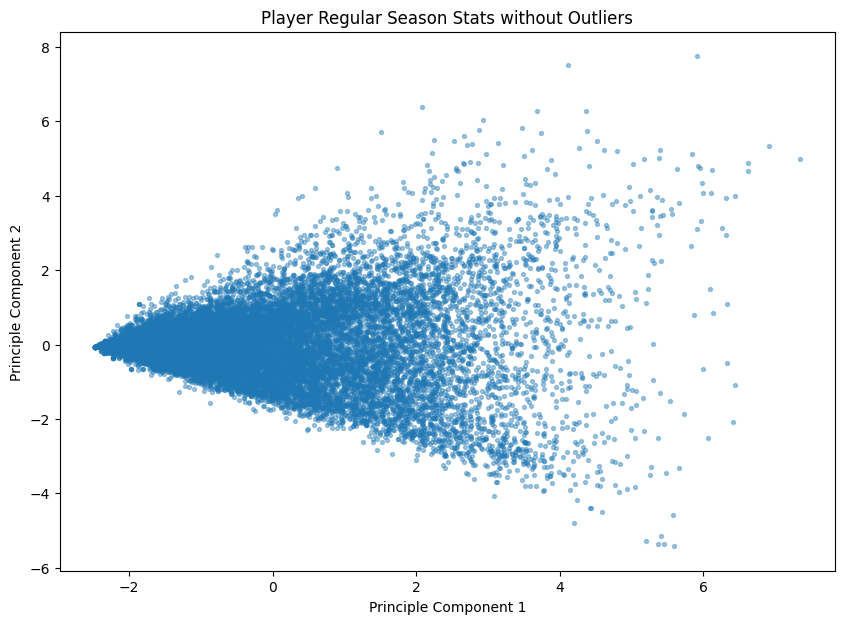

In [33]:
# plot without outliers
plt.figure(figsize=(10,7))
plt.scatter(merged_filtered['PC1'], merged_filtered['PC2'], alpha=0.4, s=8)
plt.xlabel('Principle Component 1')
plt.ylabel('Principle Component 2')
plt.title('Player Regular Season Stats without Outliers')
plt.show()

##Principle Component Analysis Visualization

In [34]:
# compute distance from center
center = pc.mean(axis=0)
dist = np.linalg.norm(pc - center, axis=1)
merged_filtered['dist'] = dist

# choose threshold (0.1% farthest points)
threshold = np.percentile(dist, 99.9)
outliers = merged_filtered[merged_filtered['dist'] > threshold]

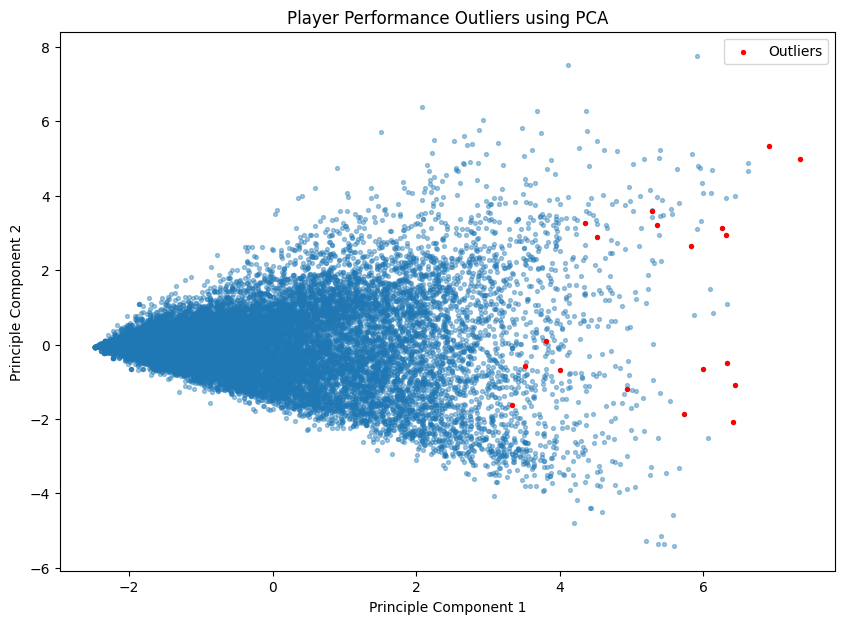

Top PCA outliers:
      firstname      lastname team  year   pts  minutes
951        Wilt   Chamberlain  PH1  1960  3033     3773
1050       Wilt   Chamberlain  PH1  1961  4029     3882
1160       Wilt   Chamberlain  SFW  1962  3586     3806
4607        Bob        Mcadoo  BUF  1974  2831     3539
4611     George      Mcginnis  IND  1974  2353     3193
4779     Kareem  Abdul-jabbar  LAL  1975  2275     3379
6092      Moses        Malone  HOU  1978  2031     3390
7181      Moses        Malone  HOU  1981  2520     3398
8973    Michael        Jordan  CHI  1986  3041     3281
9372    Michael        Jordan  CHI  1987  2868     3311
9799    Michael        Jordan  CHI  1988  2633     3255
10248   Michael        Jordan  CHI  1989  2753     3197
10341    Hakeem      Olajuwon  HOU  1989  1995     3124
12228     David      Robinson  SAS  1993  2383     3241
15957   Antoine        Walker  BOS  2000  1892     3396
16318      Paul        Pierce  BOS  2001  2144     3305
16406   Antoine        Walker 

In [35]:
# plot
plt.figure(figsize=(10,7))
plt.scatter(merged_filtered['PC1'], merged_filtered['PC2'], alpha=0.4, s=8)
plt.scatter(outliers['PC1'], outliers['PC2'], color='red', s=8, label='Outliers')
plt.xlabel('Principle Component 1')
plt.ylabel('Principle Component 2')
plt.title('Player Performance Outliers using PCA')
plt.legend()
plt.show()

print("Top PCA outliers:")
print(outliers[['firstname','lastname','team','year','pts','minutes']].head(20))

##Isolation Forest

In [36]:
isoForest = IsolationForest(
    n_estimators=300,
    contamination=0.01,
    random_state=42
)
preds = isoForest.fit_predict(merged_X_scaled)
scores = isoForest.decision_function(merged_X_scaled)

merged_filtered['Iso_Outlier'] = preds
merged_filtered['Iso_Score'] = scores

iso_outliers = merged_filtered[merged_filtered['Iso_Outlier'] == -1]
iso_outliers = iso_outliers.sort_values(by='Iso_Score')

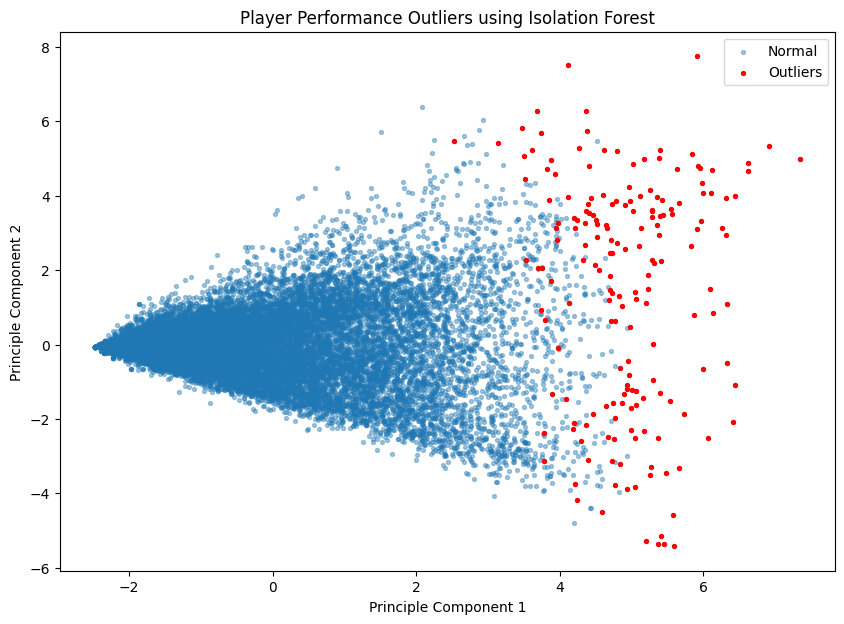

Top 20 Isolation Forest outliers:
      firstname      lastname team  year   pts  minutes
4779     Kareem  Abdul-jabbar  LAL  1975  2275     3379
9884     Hakeem      Olajuwon  HOU  1988  2034     3024
10341    Hakeem      Olajuwon  HOU  1989  1995     3124
11689    Hakeem      Olajuwon  HOU  1992  2140     3242
4011     Kareem  Abdul-jabbar  MIL  1973  2191     3548
10792    Hakeem      Olajuwon  HOU  1990  1187     2062
12228     David      Robinson  SAS  1993  2383     3241
3715     Julius        Erving  VIR  1972  2268     2993
11297     David      Robinson  SAS  1991  1578     2564
12183    Hakeem      Olajuwon  HOU  1993  2184     3277
4611     George      Mcginnis  IND  1974  2353     3193
9372    Michael        Jordan  CHI  1987  2868     3311
4220        Bob        Mcadoo  BUF  1973  2261     3185
4379     Kareem  Abdul-jabbar  MIL  1974  1949     2747
12633    Hakeem      Olajuwon  HOU  1994  2005     2853
9799    Michael        Jordan  CHI  1988  2633     3255
10836     Davi

<Figure size 640x480 with 0 Axes>

In [37]:
plt.figure(figsize=(10, 7))
plt.scatter(
    merged_filtered['PC1'],
    merged_filtered['PC2'],
    alpha=0.4, s=8, label='Normal')
plt.scatter(
    iso_outliers['PC1'],
    iso_outliers['PC2'],
    color='red', s=8, label='Outliers'
)

plt.title('Player Performance Outliers using Isolation Forest')
plt.xlabel('Principle Component 1')
plt.ylabel('Principle Component 2')
plt.legend()
plt.show()
plt.savefig("iso_outliers.png", dpi=300, bbox_inches="tight")

top20_iso = iso_outliers[['firstname', 'lastname', 'team', 'year', 'pts', 'minutes']].head(20)
top20_iso.to_csv("top20_iso_outliers.csv", index=False)
print("Top 20 Isolation Forest outliers:")
print(top20_iso)

##K-means clustering

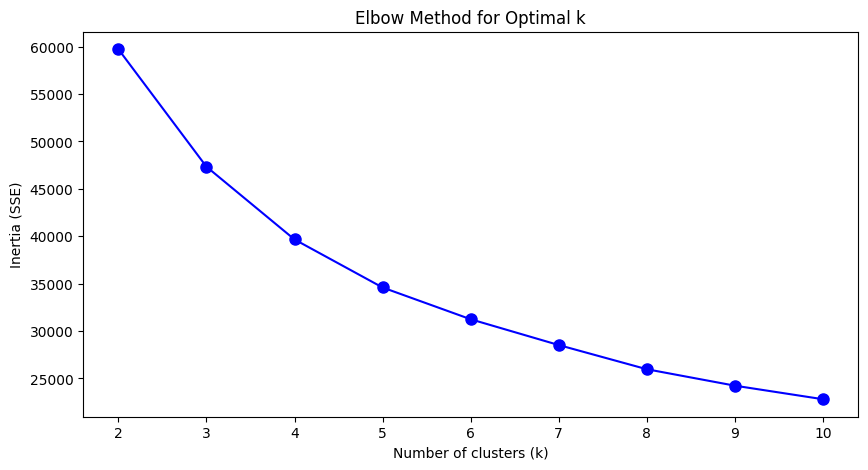

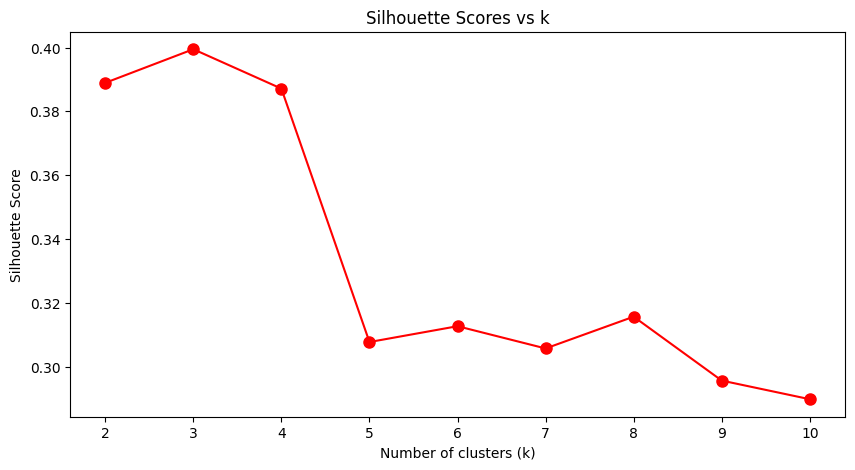

Optimal number of clusters: 3


In [38]:
# finding optimal number of clusters
inertia = []
sil_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(merged_X_scaled)
    inertia.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(merged_X_scaled, labels))

# Plot elbow
plt.figure(figsize=(10,5))
plt.plot(K_range, inertia, 'bo-', markersize=8)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (SSE)')
plt.title('Elbow Method for Optimal k')
plt.show()

# Plot silhouette
plt.figure(figsize=(10,5))
plt.plot(K_range, sil_scores, 'ro-', markersize=8)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores vs k')
plt.show()

optimal_k = K_range[np.argmax(sil_scores)]
print(f"Optimal number of clusters: {optimal_k}")


In [39]:
# fitting kmeans and assigning the clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
merged['cluster'] = kmeans.fit_predict(merged_X_scaled)

distances = np.array([
    np.linalg.norm(x - kmeans.cluster_centers_[c])
    for x, c in zip(merged_X_scaled, merged['cluster'])
])
merged['distance_to_center'] = distances
cluster_std = {
    i: np.linalg.norm(merged_X_scaled[merged['cluster']==i] - kmeans.cluster_centers_[i], axis=1).std()
    for i in range(optimal_k)
}
merged['is_outlier'] = [
    dist > 3*cluster_std[c] for dist, c in zip(distances, merged['cluster'])
]
# Flag outlier
threshold = np.percentile(distances, 99.7)
merged['is_outlier'] = merged['distance_to_center'] > threshold

outliers = merged[merged['is_outlier']]
print(f"Detected {len(outliers)} potential outliers.")
print(outliers[['firstname', 'lastname', 'cluster','distance_to_center'] + features])

# top players by distance
top_players = merged.sort_values(['cluster','distance_to_center'], ascending=[False, False]).head(20)
print("Top 20 K-means Clustering outliers:")
print(top_players[['firstname','lastname','cluster','distance_to_center'] + features])

Detected 55 potential outliers.
      firstname      lastname  cluster  distance_to_center        ppg  \
850        Wilt   Chamberlain        2            7.381468  37.597222   
951        Wilt   Chamberlain        2            7.507658  38.392405   
1050       Wilt   Chamberlain        2            8.303189  50.362500   
1119      Oscar     Robertson        1            5.801418  30.784810   
1160       Wilt   Chamberlain        2            7.452539  44.825000   
1278       Wilt   Chamberlain        2            6.382377  36.850000   
1354       Bill       Russell        2            5.887233  14.974359   
1401       Wilt   Chamberlain        2            6.654792  38.947368   
1402       Wilt   Chamberlain        2            6.153701  34.712329   
1492       Bill       Russell        2            5.775079  14.128205   
1539       Wilt   Chamberlain        2            6.684823  33.531646   
1667       Wilt   Chamberlain        2            6.574165  24.148148   
1829       Wilt   C

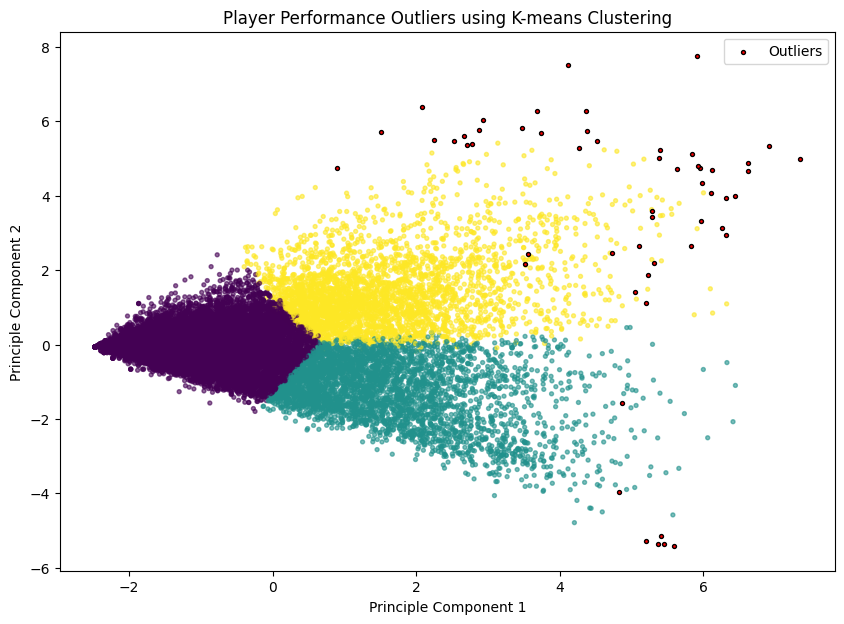

In [40]:
X_pca = pca.fit_transform(merged_X_scaled)

plt.figure(figsize=(10,7))
# Normal players
plt.scatter(X_pca[~merged['is_outlier'],0], X_pca[~merged['is_outlier'],1],
            c=merged[~merged['is_outlier']]['cluster'], cmap='viridis', alpha=0.6, s=8)
# Outliers in red
plt.scatter(X_pca[merged['is_outlier'],0], X_pca[merged['is_outlier'],1],
            c='red', edgecolor='k', label='Outliers', s=8)
plt.title("Player Performance Outliers using K-means Clustering")
plt.xlabel("Principle Component 1")
plt.ylabel("Principle Component 2")
plt.legend()
plt.show()

#Game Prediction

##Helper Functions

In [20]:
def display_results(type, y_pred, y_prob):
  print(f"{type} Performance:")
  print("Accuracy:", accuracy_score(y_test, y_pred))
  print("Log-loss:", log_loss(y_test, y_prob))
  print("Brier Score:", brier_score_loss(y_test, y_prob[:,1]))
  print("ROC-AUC:", roc_auc_score(y_test, y_prob[:,1]))
  print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
  print(classification_report(y_test, y_pred))

##Support Vector Machines

In [21]:
svm = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True)
svm.fit(game_train_scaled, y_train)

# evaluate
y_pred_svm = svm.predict(game_test_scaled)
y_prob_svm = svm.predict_proba(game_test_scaled)
display_results("Support Vector Machine", y_pred_svm, y_prob_svm)

Support Vector Machine Performance:
Accuracy: 0.9228238109482501
Log-loss: 0.18273809150667011
Brier Score: 0.05503669886925892
ROC-AUC: 0.9801062662679888
Confusion Matrix:
 [[1619  121]
 [ 137 1466]]
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      1740
           1       0.92      0.91      0.92      1603

    accuracy                           0.92      3343
   macro avg       0.92      0.92      0.92      3343
weighted avg       0.92      0.92      0.92      3343



##Random Forest

In [22]:
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    random_state=42
)

# Train Random Forest
rf_model.fit(game_train_scaled, y_train)

# Evaluate Random Forest
y_pred_rf = rf_model.predict(game_test_scaled)
y_prob_rf = rf_model.predict_proba(game_test_scaled)
display_results("Random Forest", y_pred_rf, y_prob_rf)

Random Forest Performance:
Accuracy: 0.9183368232126832
Log-loss: 0.25240004942041183
Brier Score: 0.07045539934190846
ROC-AUC: 0.9780015559905636
Confusion Matrix:
 [[1617  123]
 [ 150 1453]]
              precision    recall  f1-score   support

           0       0.92      0.93      0.92      1740
           1       0.92      0.91      0.91      1603

    accuracy                           0.92      3343
   macro avg       0.92      0.92      0.92      3343
weighted avg       0.92      0.92      0.92      3343



##Gradient Boosting Classifier

In [23]:
gb_model = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

# Train Gradient Boosting
gb_model.fit(game_train_scaled, y_train)

# Evaluate Gradient Boosting
y_pred_gb = gb_model.predict(game_test_scaled)
y_prob_gb = gb_model.predict_proba(game_test_scaled)
display_results("Gradient Boosting", y_pred_gb, y_prob_gb)

Gradient Boosting Performance:
Accuracy: 0.9291055937780437
Log-loss: 0.1710191704813049
Brier Score: 0.05085992066589213
ROC-AUC: 0.9834426829005958
Confusion Matrix:
 [[1634  106]
 [ 131 1472]]
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      1740
           1       0.93      0.92      0.93      1603

    accuracy                           0.93      3343
   macro avg       0.93      0.93      0.93      3343
weighted avg       0.93      0.93      0.93      3343



##Logistic Regression

In [24]:
param_grid ={'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l2']}
clf = GridSearchCV(LogisticRegression(max_iter=1000, solver='liblinear'), param_grid, cv=5)

# Train Logistic Regression
clf.fit(game_train_scaled, y_train)

print("Best params:", clf.best_params_)
print("Best CV score:", clf.best_score_)

# Evaluate Logistic Regression
y_pred_lr = clf.predict(game_test_scaled)
y_prob_lr = clf.predict_proba(game_test_scaled)
display_results("Logistic Regression", y_pred_lr, y_prob_lr)

Best params: {'C': 100, 'penalty': 'l2'}
Best CV score: 0.9295911268687703
Logistic Regression Performance:
Accuracy: 0.9285073287466348
Log-loss: 0.16297928469288295
Brier Score: 0.049820534569580036
ROC-AUC: 0.9838456629451963
Confusion Matrix:
 [[1629  111]
 [ 128 1475]]
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      1740
           1       0.93      0.92      0.93      1603

    accuracy                           0.93      3343
   macro avg       0.93      0.93      0.93      3343
weighted avg       0.93      0.93      0.93      3343



##XGBoost

In [25]:
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.03,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=2 ,
    reg_lambda=2.0,
    reg_alpha=1.0 ,
    random_state=42
)

# Train XGBoost
xgb_model.fit(game_train_scaled, y_train)

# Evaluate XGBoost
y_pred_xg = xgb_model.predict(game_test_scaled)
y_prob_xg = xgb_model.predict_proba(game_test_scaled)
display_results("XGBoost", y_pred_xg, y_prob_xg)

XGBoost Performance:
Accuracy: 0.9252168710738857
Log-loss: 0.2167724549118988
Brier Score: 0.06079182742619306
ROC-AUC: 0.9798047482808814
Confusion Matrix:
 [[1625  115]
 [ 135 1468]]
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      1740
           1       0.93      0.92      0.92      1603

    accuracy                           0.93      3343
   macro avg       0.93      0.92      0.93      3343
weighted avg       0.93      0.93      0.93      3343



#Ensembling best models

In [31]:
stack_model = StackingClassifier(
    estimators=[
        ('lr', clf),
        ('gb', gb_model),
    ],
    final_estimator=LogisticRegression(max_iter=1000, solver='liblinear'),
    cv=5,
    stack_method='predict_proba',
    passthrough=True
)

stack_model.fit(game_train_scaled, y_train)

y_pred_stack = stack_model.predict(game_test_scaled)
y_prob_stack = stack_model.predict_proba(game_test_scaled)
display_results("Stacking", y_pred_stack, y_prob_stack)

Stacking Performance:
Accuracy: 0.9279090637152259
Log-loss: 0.1620453287146165
Brier Score: 0.04927021294151595
ROC-AUC: 0.9841565025347588
Confusion Matrix:
 [[1629  111]
 [ 130 1473]]
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      1740
           1       0.93      0.92      0.92      1603

    accuracy                           0.93      3343
   macro avg       0.93      0.93      0.93      3343
weighted avg       0.93      0.93      0.93      3343



#Model Exporting

In [41]:
joblib.dump(isoForest, "isoForest_model.pkl")
joblib.dump(stack_model, "stack_model.pkl")

joblib.dump(scaler, "scaler.pkl")

print("Models saved successfully.")

Models saved successfully.
